##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Recuperados)

In [1]:
import numpy as np
import scipy
import scipy.integrate

def seir_model(SEIR, beta, sigma, gamma):
    S, E, I, R = SEIR
    
    # Poblacion
    N = S + E + I + R
    
    dS = - beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    return [
        dS, dE, dI, dR
    ]

Diferencias en los valores respecto a las razones de cambio:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  

In [2]:
def run(SEIR, beta, sigma, gamma, days=1, step=0.1):
    steps = np.arange(start=0, stop=days, step=step)
    return scipy.integrate.solve_ivp(
        lambda _, SEIR_t: seir_model(SEIR_t, beta, sigma, gamma),
        y0 = SEIR,
        t_eval = steps,
        t_span = (0, days)
    )

Integramos el sistema de ecuaciones diferenciales en el intervalo [0, days)

In [3]:
from matplotlib import pyplot

def plot(x, *curves):
    fig, ax = pyplot.subplots()
    for curve in curves:
        ax.plot(x[:len(curve)], curve)
    

In [4]:
R0 = 3.6
periodo_incubacion = 5.2
periodo_infeccioso = 12.4

`Rt` es el numero reproductivo, representando el numero promedio de nuevas infecciones en el tiempo `t` por infectado.  
Si `Rt` es < 1 la incidencia de nuevas enfermedades decrece, si es > 1 aumenta hasta alcanzar inmunidad de grupo.  
`R0` es este numero antes de cualquier intervencion.

In [5]:
susceptibles_t0 = 11e6
expuestos_t0 = 7
infectados_t0 = 5
dias_simulados = 48

SEIR_t0 = (
    susceptibles_t0,
    expuestos_t0,
    infectados_t0,
    0
)
solution = run(
    SEIR_t0,
    beta = R0 / periodo_infeccioso,
    sigma = 1 / periodo_incubacion,
    gamma = 1 / periodo_infeccioso,
    days = dias_simulados,
    step = 1
)

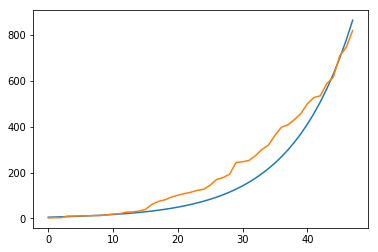

In [6]:
import csv

# https://github.com/mauforonda
with open('./data/covid19-bolivia2/nacional.csv') as f:
    csv_file = csv.reader(f)
    data = [int(line[1]) for idx, line in enumerate(csv_file) if idx > 0]
    
plot(solution['t'], solution['y'][2], data)